In [372]:

IMAGE_DIR = "/home/nipun/Documents/Uni_Malta/Datasets/Center_Regression/Mix_Iris_Center_Gi42_BioId_H2HEAD_mp2gaze/Images"


trn_df = pd.read_csv("/home/nipun/Documents/Uni_Malta/Datasets/Center_Regression/Mix_Iris_Center_Gi42_BioId_H2HEAD_mp2gaze/mix_train.csv")
val_df = pd.read_csv("/home/nipun/Documents/Uni_Malta/Datasets/Center_Regression/Mix_Iris_Center_Gi42_BioId_H2HEAD_mp2gaze/mix_val.csv")


In [373]:
def double_conv(input_channels,output_channels):
    return nn.Sequential(nn.Conv2d(input_channels,output_channels,kernel_size=3,stride=1,padding='same'),
                         nn.BatchNorm2d(output_channels),
                         nn.ReLU(),
                         nn.Conv2d(output_channels,output_channels,kernel_size=3,stride=1,padding='same'),
                         nn.BatchNorm2d(output_channels),
                         nn.ReLU())

In [374]:
class UNET(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        self.conv_1 = double_conv(3,64)
        self.mx_1 = nn.MaxPool2d(kernel_size=(2,2))
        
        
        self.conv_2 = double_conv(64,128)
        self.mx_2 = nn.MaxPool2d(kernel_size=(2,2))
        
        
        self.conv_3 = double_conv(128,256)
        self.mx_3 = nn.MaxPool2d(kernel_size=(2,2))
        
        
        
        self.conv_4 = double_conv(256,512)
        self.mx_4 = nn.MaxPool2d(kernel_size=(2,2))
        
        
        
        self.conv_5 = double_conv(512,1024)
        
        
        
        self.up_1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2)
        
        
        
        self.conv6 = double_conv(1024,512)
       
       
        self.up_2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        
        
        
        self.conv7 = double_conv(512,256)
        
        
        self.up_3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        
        
        self.conv8 = double_conv(256,128)
        

        self.up_4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        
        self.conv9 = double_conv(128,64)
        
        self.out_conv = nn.Conv2d(64,self.num_classes,kernel_size=1)
        
    def forward(self,x):

        
        x1 = self.conv_1(x)  # 1, 64, 64,64
        
        x1_max = self.mx_1(x1)
        
        
        
        x2 = self.conv_2(x1_max)  # 1, 128, 32, 32
        x2_max = self.mx_2(x2)
        
        x3 = self.conv_3(x2_max)  # 1, 256, 16,16
        x3_max = self.mx_3(x3)
        
        
        x4 = self.conv_4(x3_max) # 1, 512, 8, 8
        x4_max = self.mx_4(x4)
        
        
        
        # Bridge
        
        x5 = self.conv_5(x4_max)  # 1, 1024, 4, 4
       
        
        
        x6 = self.up_1(x5) # [1, 512, 8, 8]
      
        
        
        decoder_1 = torch.concat([x6,x4],dim=1) # 1, 1024, 8, 8]
        
        
        decoder_1 = self.conv6(decoder_1)  # [1, 512, 8, 8]
        
        
        
        
        d_2 = self.up_2(decoder_1)
        
        decoder_2 = torch.concat([d_2,x3],dim=1) # [1, 512, 16, 16]
        
        decoder_2 = self.conv7(decoder_2) # [1, 256, 16, 16]
        
       
        d_3 = self.up_3(decoder_2)
        
        decoder_3 = torch.concat([d_3,x2],dim=1)
        
        decoder_3 = self.conv8(decoder_3) # [1, 128, 32, 32]
        
        
        d_4 = self.up_4(decoder_3)
        decoder_4 = torch.concat([d_4,x1],dim=1)
        
        decoder_4 = self.conv9(decoder_4) # 1, 64, 64, 64
        
        output = self.out_conv(decoder_4).view(-1,self.num_classes*x.shape[2]*x.shape[3])
        
        return output

In [389]:
def jaccard_index(y_true,y_pred):
    """Return Mean of Jaccard Index for Batch """
    intersection = torch.sum(torch.abs(y_pred * y_true),axis=-1)
    union = torch.sum((torch.abs(y_true) + torch.abs(y_pred)),axis=-1)
    smooth = 1e-5
    jaccard_index  = torch.div(union+smooth,union-intersection+smooth)
    
    return jaccard_index.mean()

In [376]:
def mean_squared_error(y_true,y_pred):
    """ Return MSE for the Batch"""
    return torch.sum(torch.square(y_pred-y_true),axis=-1).mean()

In [377]:


class CenterDataset(torch.utils.data.Dataset):
    def __init__(self,df,image_dir=IMAGE_DIR,RESIZE_AMT=64):
        
        self.RESIZE_AMT = RESIZE_AMT
        self.image_dir = image_dir
        self.df = df
        self.image_ids = df.Image_Name.unique()
        self.transforms = transforms
        
    # apply gaussian kernel to image
    def _gaussian(self, xL, yL, sigma, H, W):

        channel = [math.exp(-((c - xL) ** 2 + (r - yL) ** 2) / (2 * sigma ** 2)) for r in range(H) for c in range(W)]
        channel = np.array(channel, dtype=np.float32)
        channel = np.reshape(channel, newshape=(H, W))

        return channel
    
    
    
    
    # convert original image to heatmap
    def _convertToHM(self, img, keypoints, sigma=2):

        H = img.shape[0] 
        W =  img.shape[1]
        nKeypoints = len(keypoints)

        img_hm = np.zeros(shape=(H, W, nKeypoints // 2), dtype=np.float32)

        for i in range(0, nKeypoints // 2):
            x = keypoints[i * 2]
            y = keypoints[1 + 2 * i]

            channel_hm = self._gaussian(x, y, sigma, H, W)

            img_hm[:, :, i] = channel_hm
        

        return img_hm
    def __getitem__(self,ix):
        
        img_id = self.image_ids[ix]
        img_path = os.path.join(self.image_dir,img_id)
        
        img = cv2.imread(img_path)[:,:,::-1]
        
        
        img = cv2.resize(img,(self.RESIZE_AMT,self.RESIZE_AMT))
        
        img = img/255.0
        
        
        
        data = self.df[self.df["Image_Name"]==img_id]
        
        
        x1 = data["X1"].values[0] * self.RESIZE_AMT
        y1 = data["Y1"].values[0] * self.RESIZE_AMT
        
        
        heatmap = torch.tensor(self._convertToHM(img,[x1,y1]),dtype=torch.float32).permute(2,0,1).view(1*self.RESIZE_AMT*self.RESIZE_AMT)
        
        image = torch.tensor(img,dtype=torch.float32).permute(2,0,1)
        
        
        return image,heatmap
        
    def collate_fn(self,batch):
        return tuple(zip(*batch))
    
    def __len__(self):
        return len(self.image_ids)

In [378]:
train_ds = CenterDataset(trn_df)
test_ds = CenterDataset(val_df)

In [586]:
img,hm = train_ds[5]

In [589]:
# len(torch.unique(hm))

2493

In [379]:
BACTH_SIZE = 4

In [380]:
trainLoader = DataLoader(train_ds, batch_size=BACTH_SIZE,
	shuffle=True, num_workers=os.cpu_count(), pin_memory=True,drop_last=True)
testLoader = DataLoader(test_ds, batch_size=BACTH_SIZE,
	num_workers=os.cpu_count(), pin_memory=True,drop_last=True)



In [390]:
def main(model,trainLoader,testLoader,optimizer,epochs=100):
    
        for epoch in range(epochs):
            train_epoch_mse_loss=trainStep(model,trainLoader,optimizer)
            val_mse,val_jaccard=valStep(model,testLoader)
            
            print(f"Epoch {epoch+1}| Train MSE Loss--> {train_epoch_mse_loss}")
            print(f"Epoch {epoch+1}| VAL MSE Loss--> {val_mse}")
            print(f"Epoch {epoch+1}| VAL Jaccard Loss--> {val_jaccard}\n")
            

In [391]:
def trainStep(model,trainLoader,optimizer):
    
    model.train()
    
    epoch_loss = 0
    
    total_step = 0
    
    for _,(x,y) in enumerate(trainLoader):
        
        x = x.to(device)
        y = y.to(device)
        
        
        optimizer.zero_grad()
        
        y_pred = model(x)
        
        loss = mean_squared_error(y,y_pred)
        
        
        loss.backward()
        optimizer.step()
        
        
        epoch_loss += loss.item()
        
        total_step += 1
        
    return epoch_loss/total_step
        
        
        

In [392]:
def valStep(model,testLoader):
    model.eval()
    
    
    total_val_mse_loss = 0
    total_val_jaccard_index = 0
    
    total_step = 0
    
    for (x,y) in testLoader:
        
        x = x.to(device)
        y = y.to(device)
        
        with torch.no_grad():
            
            y_pred = model(x)
        
        #MSE
        loss = mean_squared_error(y,y_pred).item()
        
        total_val_mse_loss += loss
        
        # Jaccard-Index
        jc_index =jaccard_index(y,y_pred).item()
        
        total_val_jaccard_index += jc_index
        
        
        total_step += 1
        
    return total_val_mse_loss/total_step,total_val_jaccard_index/total_step
        

In [501]:
def maskToKeypoints(mask):
    
    
    
    kp = np.unravel_index(np.argmax(mask, axis=None), dims=(64,64))
    return kp[1], kp[0]

def findCoordinates(mask):

    hm_sum = np.sum(mask)

    index_map = [j for i in range(64) for j in range(64)]
    index_map = np.reshape(index_map, newshape=(64,64))

    x_score_map = mask * index_map / hm_sum
    y_score_map = mask * np.transpose(index_map) / hm_sum

    px = np.sum(np.sum(x_score_map, axis=None))
    py = np.sum(np.sum(y_score_map, axis=None))

    return px, py

def calcRMSError(kps_gt, kps_preds):

    N = kps_gt.shape[0] * (kps_gt.shape[-1] // 2)
    error = np.sqrt(np.sum((kps_gt-kps_preds)**2)/N)

    return error

In [393]:
model = UNET(1).to(device)


parameters = filter(lambda p: p.requires_grad,model.parameters())

optimizer = torch.optim.Adam(parameters,lr=0.006)

In [394]:
main(model,trainLoader,testLoader,optimizer)

Epoch 1| Train MSE Loss--> 15.163975125661603
Epoch 1| VAL MSE Loss--> 4.577700767006894
Epoch 1| VAL Jaccard Loss--> 1.1431060624711307

Epoch 2| Train MSE Loss--> 3.636199209179898
Epoch 2| VAL MSE Loss--> 2.7805625939810716
Epoch 2| VAL Jaccard Loss--> 1.2274254975004941

Epoch 3| Train MSE Loss--> 2.8221791939112384
Epoch 3| VAL MSE Loss--> 3.2616402145030565
Epoch 3| VAL Jaccard Loss--> 1.2026989639050676

Epoch 4| Train MSE Loss--> 2.6323829388912814
Epoch 4| VAL MSE Loss--> 2.3620438311754923
Epoch 4| VAL Jaccard Loss--> 1.21148278389448

Epoch 5| Train MSE Loss--> 2.4111831024473096
Epoch 5| VAL MSE Loss--> 2.2580440280491434
Epoch 5| VAL Jaccard Loss--> 1.2273969341207434

Epoch 6| Train MSE Loss--> 2.2711868491100433
Epoch 6| VAL MSE Loss--> 2.156032453532572
Epoch 6| VAL Jaccard Loss--> 1.233271097695386

Epoch 7| Train MSE Loss--> 2.134209114736245
Epoch 7| VAL MSE Loss--> 2.1496359885597425
Epoch 7| VAL Jaccard Loss--> 1.233927806218465

Epoch 8| Train MSE Loss--> 2.024654

In [430]:
x,y = next(iter(testLoader))

In [431]:
pred_output = model(x.cuda())

In [432]:
unflatten = nn.Unflatten(-1,(1,64,64))

In [433]:
pred_output = unflatten(pred_output)




In [436]:
idx = 3

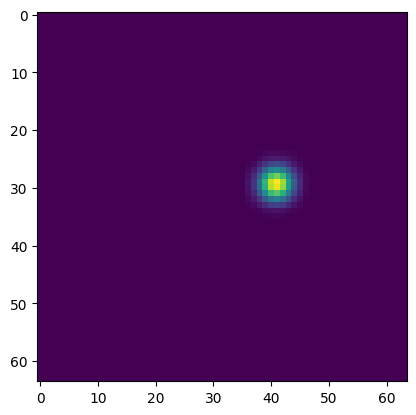

In [437]:
plt.imshow(pred_output[idx].permute(1,2,0).detach().cpu().numpy())

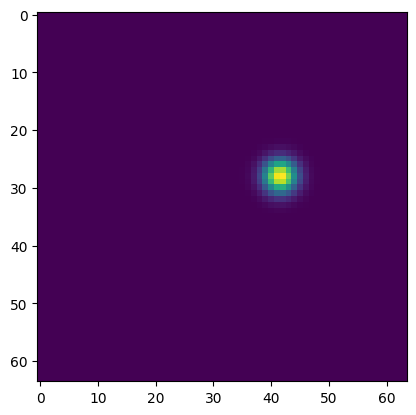

In [438]:
y_true = unflatten(y)

plt.imshow(y_true[idx].permute(1,2,0).detach().cpu().numpy())

In [316]:
x = torch.tensor([[1.,2.],
                  [3.,4.]])


y =  torch.tensor([[4.,5.],
                  [1.,2.]])

In [491]:
def calcKeypoints(model, gen):
    kps_gt = []
    kps_preds = []
    
    image_array = []
    gt_mask_array =[]
    pred_mask_array =[]
    nbatches = len(gen)
    
    unflatter = nn.Unflatten(1,(64,64))
    
    model.eval()
    
    for (x,y) in gen:
        
        x = x.to(device)
        y= y.to(device)
        
        with torch.no_grad():
            y_pred = model(x)
            
        for i in range(x.shape[0]):
            
            
            imgs = x[i].detach().cpu().permute(1,2,0).numpy()
            
            mask_gt = y[i]
            
            mask_gt = unflatten(mask_gt).detach().cpu().permute(1,2,0).numpy()
            
           
            
            mask_pred = y_pred[i]
            
            mask_pred = unflatten(mask_pred).detach().cpu().permute(1,2,0).numpy()


            
            xgt, ygt = findCoordinates(mask_gt[:, :,0])
            
            xpred, ypred = findCoordinates(mask_pred[:, :,0])
            

            image_array.append(imgs)
            gt_mask_array.append(mask_gt)
            pred_mask_array.append(mask_pred)
                        
            kps_gt.append([xgt,ygt])
            kps_preds.append([xpred,ypred])
    
    
    return image_array, gt_mask_array, pred_mask_array,kps_gt,kps_preds

        

In [498]:

# len(testLoader)

image_array, gt_mask_array, pred_mask_array,kps_gt,kps_preds = calcKeypoints(model, testLoader)


/tmp/ipykernel_272507/3148859275.py:13: RuntimeWarning: invalid value encountered in divide
  x_score_map = mask * index_map / hm_sum
/tmp/ipykernel_272507/3148859275.py:14: RuntimeWarning: invalid value encountered in divide
  y_score_map = mask * np.transpose(index_map) / hm_sum


1944

In [499]:

len(kps_preds)

1944

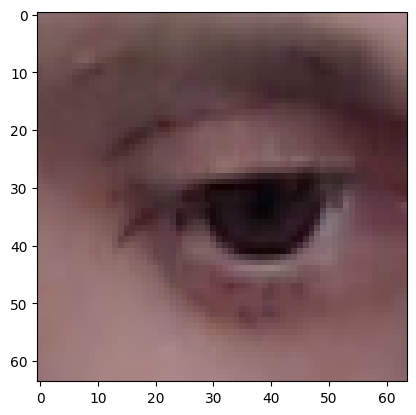

In [581]:
def showMasks(imgs, gt_masks, pred_masks, gt_coord, pred_coord, nrows=8, ncols=4):

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 25))
    plt.figure(figsize=(8, 8))

    axs[0, 0].set_title("Original Image")
    axs[0, 1].set_title("GT Masks")
    axs[0, 2].set_title("Pred Masks")
    axs[0, 3].set_title("Pred & GT Coord")


    for i in range(len(imgs)):

        axs[i, 0].imshow(imgs[i])
        axs[i, 0].axis("off")

        axs[i, 1].imshow(gt_masks[i])
        axs[i, 1].axis("off")

        axs[i, 2].imshow(pred_masks[i])
        axs[i, 2].axis("off")

        axs[i, 3].imshow(imgs[i])
        axs[i, 3].scatter(x=int(pred_coord[i][0]), y=int(
            pred_coord[i][1]), color='blue')  # Prediction Blue
        axs[i, 3].scatter(x=int(gt_coord[i][0]), y=int(
            gt_coord[i][1]), color="red")  # Ground Truth Red
        axs[i, 3].axis("off")

    plt.show()
    plt.close()


In [584]:
low_limit = 50
upper_limit = 58

8


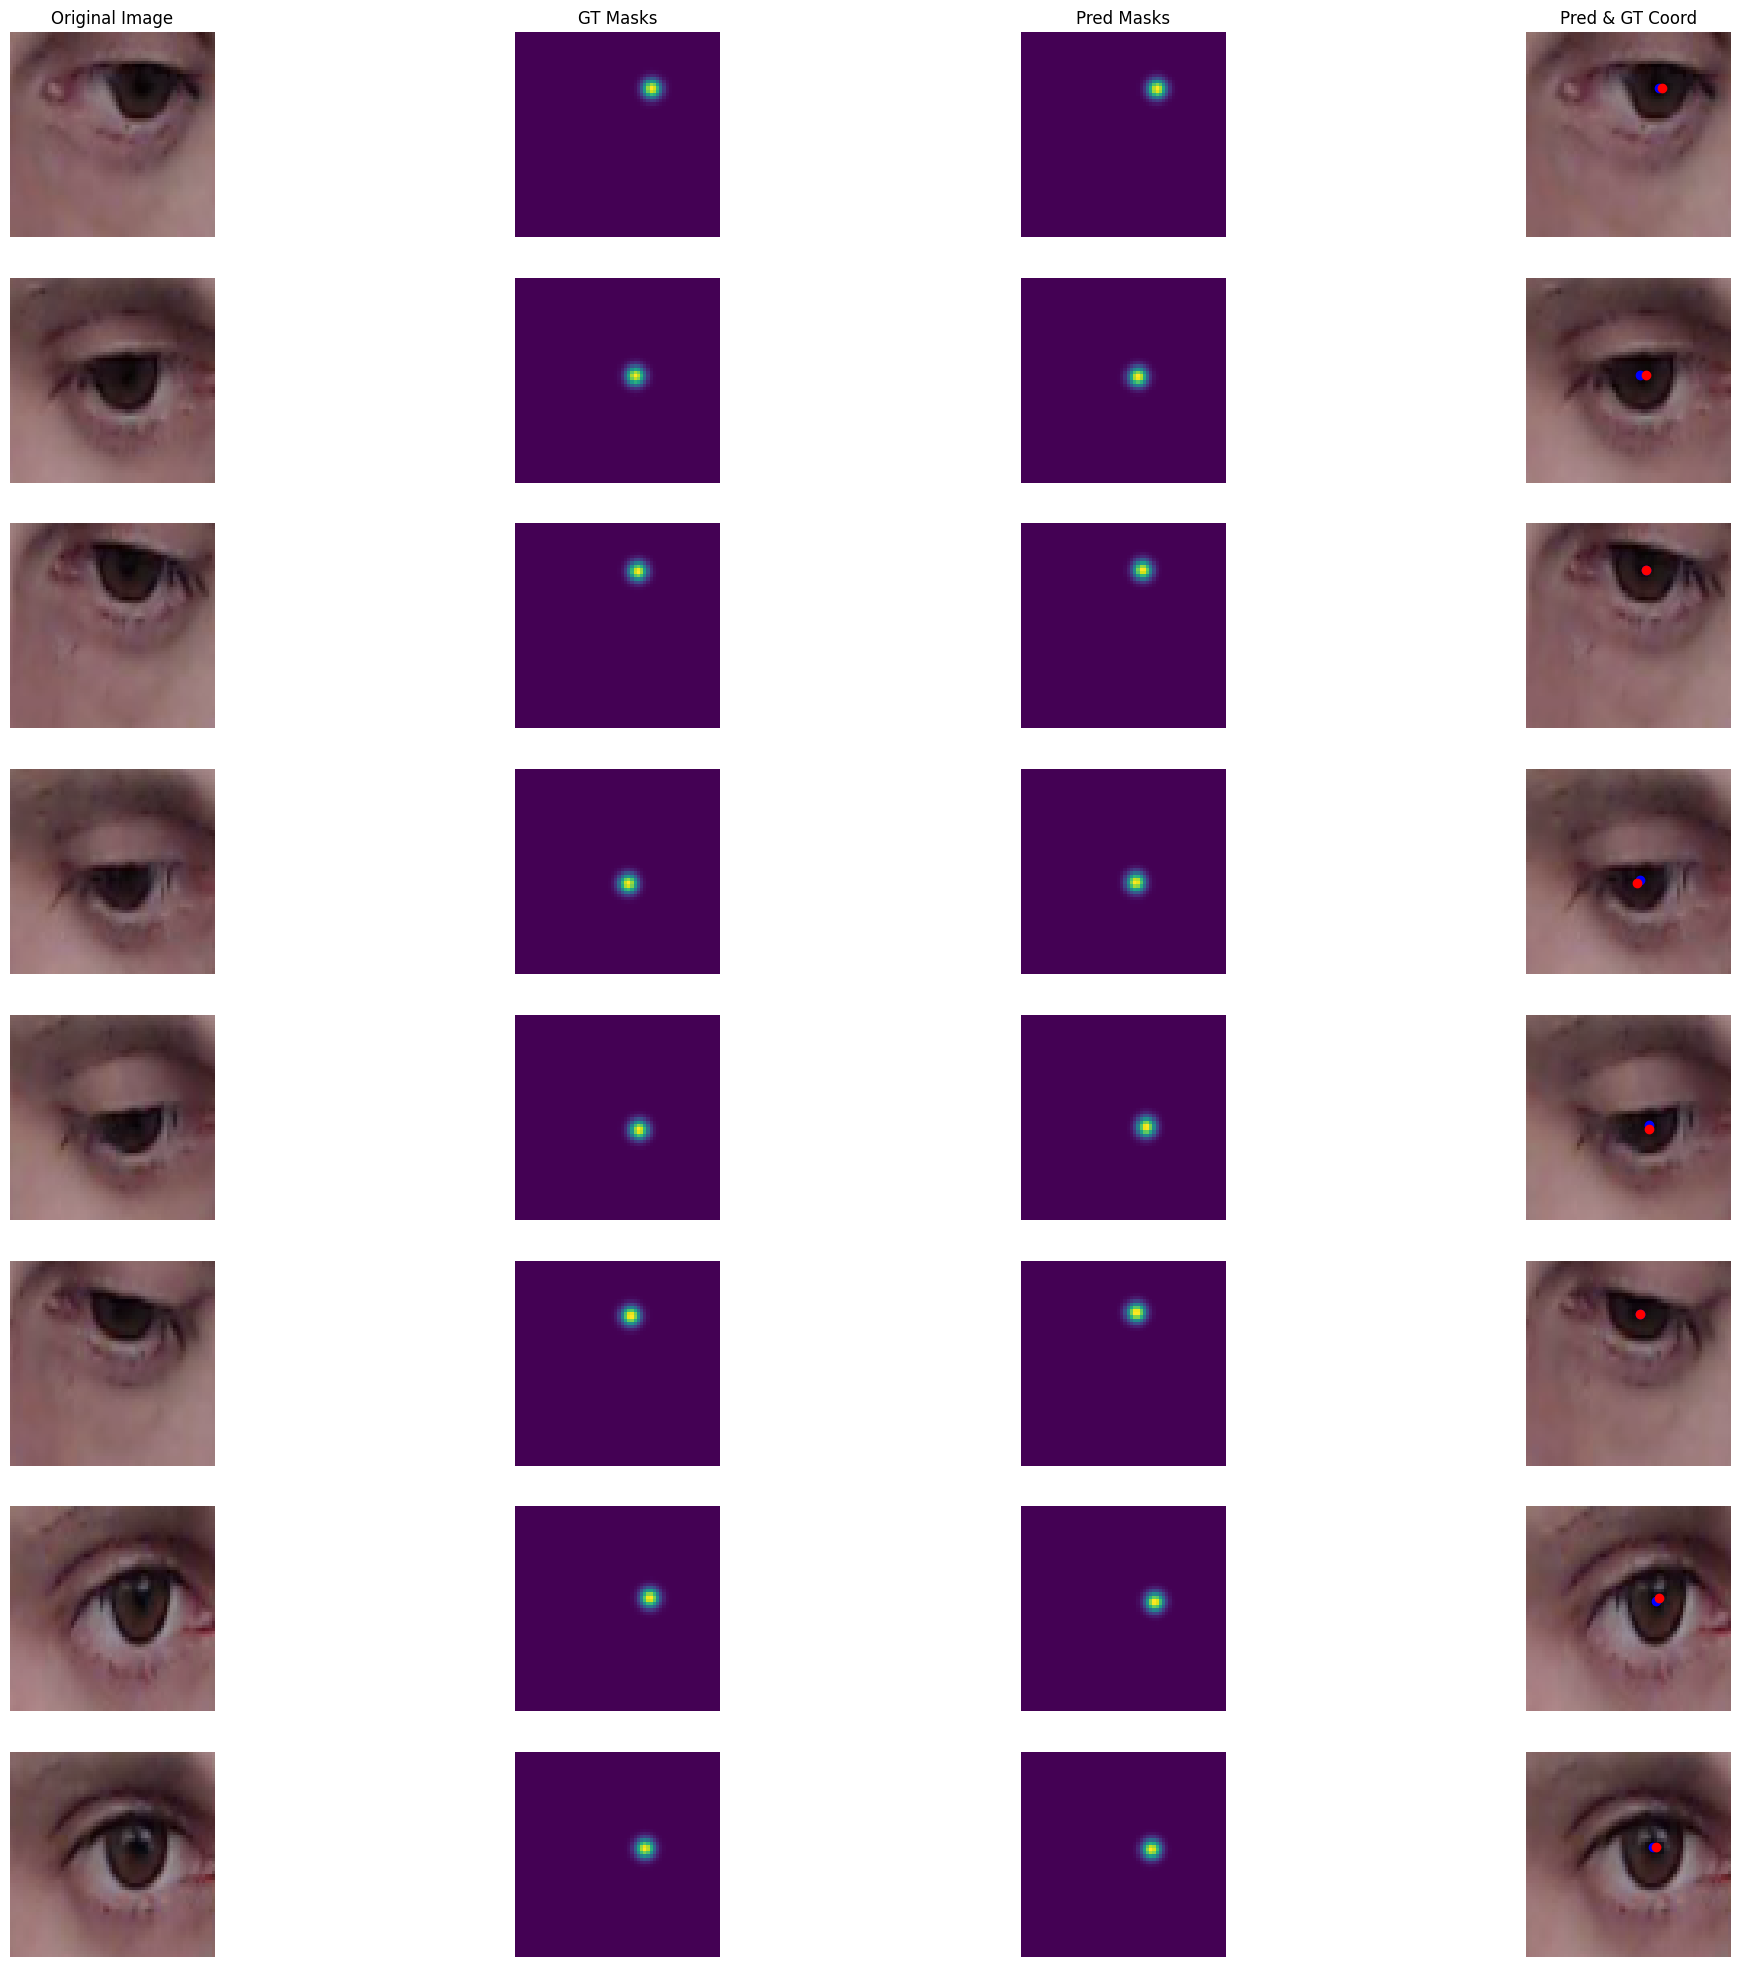

<Figure size 800x800 with 0 Axes>

In [585]:
showMasks(image_array[low_limit:upper_limit], gt_mask_array[low_limit:upper_limit], pred_mask_array[low_limit:upper_limit],kps_gt[low_limit:upper_limit],kps_preds[low_limit:upper_limit])